# System Modelling

Author : Masuk

In [2]:
# Make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

## Import of standard python libraries

In [3]:
import numpy as np
import corner
import matplotlib.pyplot as plt

%matplotlib inline

## Load imaging and psf data

In [4]:
import h5py  # library to work with '.h5' files

In [5]:
with h5py.File('./DESIJ1421-0022_F140W.h5', 'r') as f:  # loading image data
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
        
kwargs_data

{'background_rms': 0.016322818764336215,
 'dec_at_xy_0': -5.639999999999994,
 'exposure_time': array([[392.5919 , 429.8496 , 477.49698, ..., 417.0545 , 626.3687 ,
         470.51013],
        [537.5037 , 481.4545 , 402.75043, ..., 445.28027, 411.41382,
         414.60626],
        [441.50906, 430.91473, 528.3243 , ..., 582.93396, 452.38983,
         456.0343 ],
        ...,
        [455.4104 , 487.22336, 492.4171 , ..., 564.8773 , 450.29538,
         395.7962 ],
        [509.2898 , 384.29117, 459.5256 , ..., 396.0305 , 487.2688 ,
         570.89014],
        [438.19513, 478.61502, 508.9901 , ..., 350.71753, 400.08707,
         430.7757 ]], dtype=float32),
 'image_data': array([[-0.00921469, -0.02078328,  0.00167325, ..., -0.0132964 ,
         -0.03175444, -0.01695797],
        [-0.00559985, -0.01327114, -0.00524183, ...,  0.00243682,
         -0.00851916, -0.01378721],
        [ 0.00427728, -0.00057159, -0.02292269, ..., -0.01166504,
         -0.00735005, -0.00661949],
        ...,
   

In [6]:
with h5py.File('./psf_F140W.h5', 'r') as f:  # loading psf data
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
        
kwargs_psf['psf_type'] = 'PIXEL'
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15828\3580282401.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(kwargs_data['image_data']), origin='lower', cmap='cubehelix')


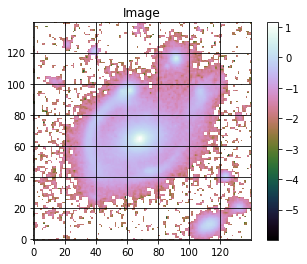

In [23]:
# extracting image_data from kwargs_data
plt.figure()
plt.imshow(np.log10(kwargs_data['image_data']), origin='lower', cmap='cubehelix')
plt.colorbar()
plt.title('Image')
plt.grid(True,color='black')

# Show the plots
plt.show()

## Masking

In [16]:
from lenstronomy.Util import mask_util
from lenstronomy.Util import util

from lenstronomy.Data.coord_transforms import Coordinates

In [17]:
ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
transform_pix2angle = kwargs_data['transform_pix2angle']

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data['image_data'])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 3.3 # arcsecond
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(lens_center_ra,
                                      lens_center_dec,
                                      r,
                                      util.image2array(x_coords),
                                      util.image2array(y_coords))
        


mask_ext_1 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+1.,
                                   lens_center_dec-3.5,
                                   0.7, 0.7, 0)

mask_ext_2 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra+3.,
                                   lens_center_dec+1.,
                                   1.9, .9, np.pi/2)
        
mask = (1 - mask_outer) * (1- mask_ext_1) * (1 - mask_ext_2)
mask[mask >= 1] = 1
mask[mask < 0] = 0

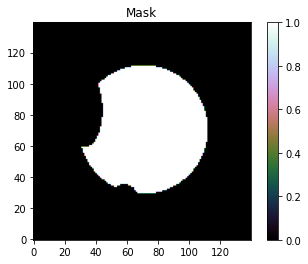

In [18]:
mask_img = mask.reshape(num_pix, num_pix)

plt.figure()
plt.imshow(mask_img, origin='lower', cmap='cubehelix')
plt.colorbar()
plt.title('Mask')

# Show the plots
plt.show()

In [17]:
plt.matshow(np.log10(mask), origin='lower', cmap='cubehelix');

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22196\4267170332.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(mask), origin='lower', cmap='cubehelix');


ValueError: not enough values to unpack (expected 2, got 1)

## Building a lens model

In [7]:
lens_model_list = ['EPL', 'SHEAR']  # adding shear into lens_model_list
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS']  # adding shapelets into source_model_list
lens_light_model_list = ['SERSIC_ELLIPSE']

### Lens galaxy's mass model

In [67]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 

fixed_lens.append({'ra_0': 0, 'dec_0': 0})

kwargs_lens_init.append({'theta_E': 1,
                         'gamma': 2.,
                         'e1': 0.,
                         'e2': 0.,
                         'center_x': 0.,
                         'center_y': 0.}) 

kwargs_lens_sigma.append({'theta_E': 0.01,
                          'gamma': .1,
                          'e1': 0.05,
                          'e2': 0.05,
                          'center_x': 0.5,
                          'center_y': 0.5}) 

kwargs_lower_lens.append({'theta_E': 0.1,
                          'gamma': 1.,
                          'e1': -0.5,
                          'e2': -0.5,
                          'center_x': -10,
                          'center_y': -10}) 

kwargs_upper_lens.append({'theta_E': 5,
                          'gamma': 3.,
                          'e1': 0.5,
                          'e2': 0.5,
                          'center_x': 10,
                          'center_y': 10})



kwargs_lens_init.append({'gamma1': 0,
                         'gamma2': 0,
                         'ra_0': 0,
                         'dec_0': 0})

kwargs_lens_sigma.append({'gamma1': .01,
                          'gamma2': .01,
                          'ra_0': 0.01,
                          'dec_0': 0.01})

kwargs_lower_lens.append({'gamma1': -0.3,
                          'gamma2': -0.3,
                          'ra_0': -2,
                          'dec_0': -2})
 
kwargs_upper_lens.append({'gamma1': 0.3,
                          'gamma2': 0.3,
                          'ra_0': 2,
                          'dec_0': 2})


lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

### Lens galaxy's light model

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({'n_sersic': 4.})

kwargs_lens_light_init.append({'R_sersic': 0.5,
                               'n_sersic': 2,
                               'e1': 0,
                               'e2': 0, 
                               'center_x': 0.,
                               'center_y': 0,
                               'amp': 1})

kwargs_lens_light_sigma.append({'n_sersic': 1,
                                'R_sersic': 0.01,
                                'e1': 0.05,
                                'e2': 0.05,
                                'center_x': 0.1,
                                'center_y': 0.1,
                                'amp': 10})

kwargs_lower_lens_light.append({'e1': -0.5,
                                'e2': -0.5,
                                'R_sersic': 0.001,
                                'n_sersic': .5,
                                'center_x': -10,
                                'center_y': -10,
                                'amp': 0})

kwargs_upper_lens_light.append({'e1': 0.5,
                                'e2': 0.5,
                                'R_sersic': 10,
                                'n_sersic': 5.,
                                'center_x': 10,
                                'center_y': 10,
                                'amp': 100}) 


joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]


lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light,
                     kwargs_lower_lens_light, kwargs_upper_lens_light]

### Source galaxy's light model

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({'n_sersic': 1.}) 

kwargs_source_init.append({'R_sersic': 0.2,
                           'n_sersic': 1,
                           'e1': 0,
                           'e2': 0,
                           'center_x': 0.,
                           'center_y': 0,
                           'amp': 1}) 

kwargs_source_sigma.append({'n_sersic': 0.5,
                            'R_sersic': 0.01,
                            'e1': 0.05,
                            'e2': 0.05,
                            'center_x': 0.2,
                            'center_y': 0.2,
                            'amp': 10})

kwargs_lower_source.append({'e1': -0.5,
                            'e2': -0.5,
                            'R_sersic': 0.001,
                            'n_sersic': .5,
                            'center_x': -10,
                            'center_y': -10,
                            'amp': 0})

kwargs_upper_source.append({'e1': 0.5,
                            'e2': 0.5,
                            'R_sersic': 10,
                            'n_sersic': 5.,
                            'center_x': 10,
                            'center_y': 10,
                            'amp': 100})



fixed_source.append({'n_max': 5})

kwargs_source_init.append({'beta': 1.,
                           'n_max': 5,
                           'center_x': 0.,
                           'center_y': 0.})

kwargs_source_sigma.append({'beta': 10,
                            'n_max': 0.1,
                            'center_x': 0.2,
                            'center_y': 0.2})

kwargs_lower_source.append({'beta': 0.01,
                            'n_max': 2,
                            'center_x': -10,
                            'center_y': -10})

kwargs_upper_source.append({'beta': 100,
                            'n_max': 8,
                            'center_x': 10,
                            'center_y': 10})


joint_centroid = [[0, 1, ['center_x', 'center_y']]]


source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source,
                 kwargs_lower_source, kwargs_upper_source]

### Combining all the above specification in the `kwargs_params` dictionary

In [ ]:
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}

kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light,
                      'joint_source_with_source': joint_centroid
                      }

### Numerical settings

In [68]:
kwargs_likelihood = {'check_bounds': True}

kwargs_numerics = {'supersampling_factor': 1,  # Oversample the image plane by 2 when computing
                                               # the lensed image for better accuracy
                   'supersampling_convolution': False
                   }

### Combining all the information to be sent to lenstronomy

In [69]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'
                    }

## Here the model fitting is done

In [70]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints,
                              kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200,  # using Particle Swarm Optimization
                                'n_iterations': 100}],
                      ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.1370179192308982 reduced X^2 of best position
-5663.486255689104 log likelihood
9962 effective number of data points
[{'theta_E': 0.8101351371860528, 'gamma': 1.755421345293914, 'e1': 0.11589096305428974, 'e2': -0.06293244398360595, 'center_x': -0.08237535825885914, 'center_y': 0.1926950648929744}, {'gamma1': -0.02071727642213345, 'gamma2': -0.08345219990215509, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.23815650973143365, 'n_sersic': 1.0, 'e1': -0.12996016528313806, 'e2': -0.06159985483018225, 'center_x': 0.011883567082495767, 'center_y': 0.09585868854606852}, {'amp': 1, 'n_max': 5, 'beta': 0.02531754317565283, 'center_x': 0.011883567082495767, 'center_y': 0.09585868854606852}] source result
[{'amp': 1, 'R_sersic': 0.5270192536566565, 'n_sersic': 4.0, 'e1': 0.11589096305428974, 'e2': -0.06293244398360595, 'center_x': -0.08237535825885914, 'center_y': 0.1926950648929744}] lens li

## Visualizing the fitted model

-1.1326972511378208 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.1326972511378208


<ipython-input-71-894a431a6cee>:17: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


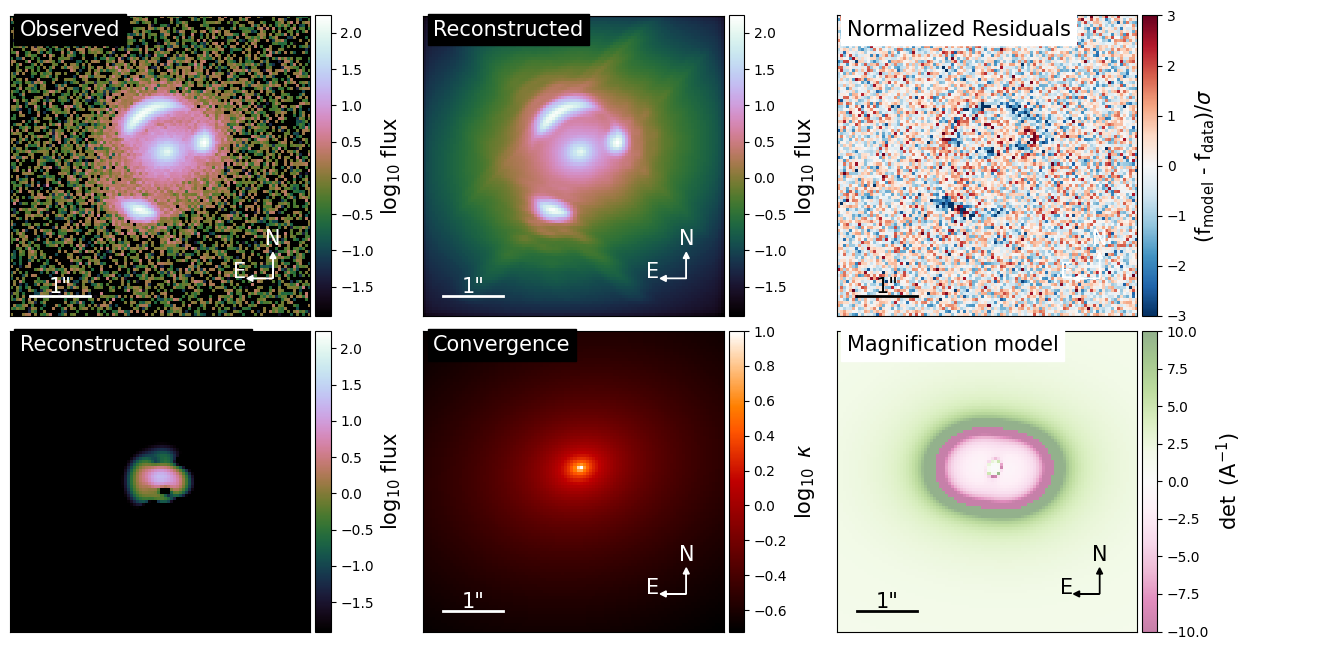

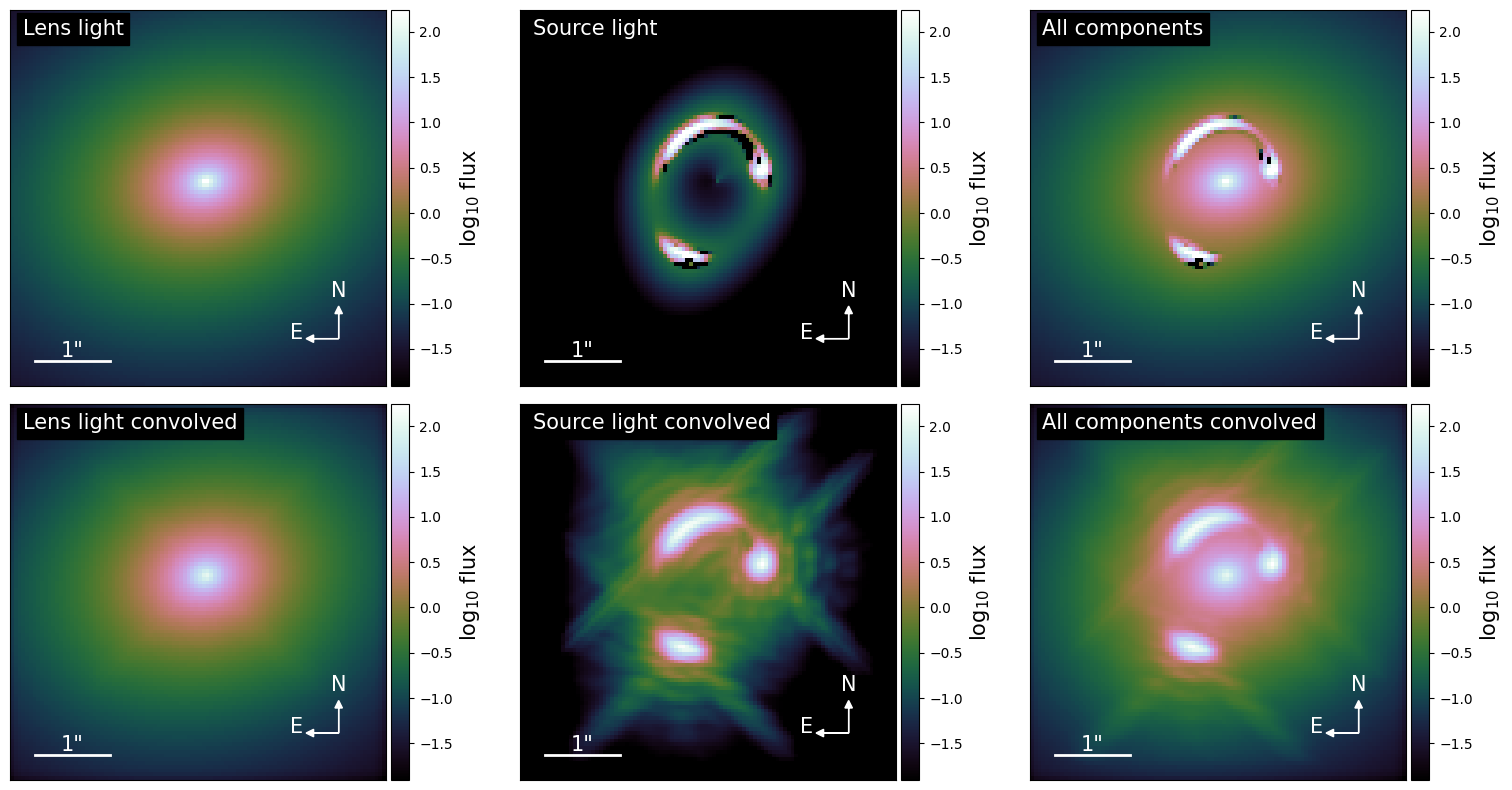

{'kwargs_lens': [{'theta_E': 0.8101351371860528, 'gamma': 1.755421345293914, 'e1': 0.11589096305428974, 'e2': -0.06293244398360595, 'center_x': -0.08237535825885914, 'center_y': 0.1926950648929744}, {'gamma1': -0.02071727642213345, 'gamma2': -0.08345219990215509, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.23815650973143365, 'n_sersic': 1.0, 'e1': -0.12996016528313806, 'e2': -0.06159985483018225, 'center_x': 0.011883567082495767, 'center_y': 0.09585868854606852}, {'amp': 1, 'n_max': 5, 'beta': 0.02531754317565283, 'center_x': 0.011883567082495767, 'center_y': 0.09585868854606852}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.5270192536566565, 'n_sersic': 4.0, 'e1': 0.11589096305428974, 'e2': -0.06293244398360595, 'center_x': -0.08237535825885914, 'center_y': 0.1926950648929744}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [71]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02,
                      cmap_string="cubehelix",
                      )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0,0])
model_plot.model_plot(ax=axes[0,1])
model_plot.normalized_residual_plot(ax=axes[0,2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0,0], text='Lens light', 
                              lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,0], text='Lens light convolved',
                              lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0,1], text='Source light',
                              source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,1], text='Source light convolved',
                              source_add=True)
model_plot.decomposition_plot(ax=axes[0,2], text='All components',
                              source_add=True, lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,2], text='All components convolved',
                              source_add=True, lens_light_add=True, point_source_add=True)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)